# 보스턴 집값 예측


In [145]:
# 모듈 로딩
import torch                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn           # 인공신경망 관련 모듈
import torch.nn.functional as F    # 손실, 거리 등 함 수관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈

import pandas as pd
from sklearn.model_selection import train_test_split

요약
torch.nn.functional 모듈은 신경망을 구성하고 학습하는 데 필요한 함수형 API를 제공합니다. 활성화 함수, 손실 함수, 컨볼루션, 풀링, 드롭아웃 등 다양한 딥러닝 관련 연산을 함수형으로 직접 호출하여 사용할 수 있습니다.
클래스 형태로 선언하는 방식(torch.nn)과 달리, torch.nn.functional은 필요한 연산을 함수로 직접 호출하는 방식을 지원합니다.

In [146]:
# 데이터 준비
FILE = r'C:\Users\zizonkjs\머신러닝,딥러닝\data\boston.csv'
bostondf = pd.read_csv(FILE)
bostondf


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [147]:
model = nn.Linear(13,1)

# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param} \n')

# 최적화 인스턴스준비
## 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim = optimizer.Adam(model.parameters(), lr=0.1)

# 데이터셋 Tensor화 진행
featurets = torch.from_numpy(bostondf[bostondf.columns[:-1]].values).float()
print(featurets.shape)

targetts = torch.from_numpy(bostondf[['MEDV']].values).float()
print(targetts.shape)

X_train, X_test, y_train, y_test = train_test_split(featurets, targetts, test_size=0.2)

# 검증용 만들기
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(f'Train {X_train.shape}, TEST {X_test.shape}, VAL {X_val.shape}')
print(f'Train {y_train.shape}, TEST {y_test.shape}, VAL {y_val.shape}')

[weight] Parameter containing:
tensor([[-0.2330, -0.1675,  0.2681, -0.1396,  0.0639,  0.1008, -0.0245, -0.0416,
         -0.2755, -0.2201,  0.1794, -0.1878, -0.0337]], requires_grad=True) 

[bias] Parameter containing:
tensor([-0.0166], requires_grad=True) 

torch.Size([506, 13])
torch.Size([506, 1])
Train torch.Size([323, 13]), TEST torch.Size([102, 13]), VAL torch.Size([81, 13])
Train torch.Size([323, 1]), TEST torch.Size([102, 1]), VAL torch.Size([81, 1])


In [148]:
# 테스트/검증 함수 만들기
def testing(test_ts, targetts, kind='val'):

    with torch.no_grad(): # 가중치 및 절편 업데이트 진행 금지
        # 1. 학습진행 forward
        pre_y = model(test_ts)

        # 2. 오차 계산 - 손실함수
        loss = F.mse_loss(pre_y, targetts)

        # 3. 학습결과 출력 및 저장
        print(f'[{kind}] {kind} LOSS : {loss}')
    
    return loss

In [152]:
EPOCH = 100

# 모델 학습 함수
def training(featurets, targetts, valts, valtargetts):

    loss_history= [[],[]]

    for epoch in range(EPOCH):
        # 1. 학습 진행 forward
        pre_y = model(featurets)

        # 2. 오차 계산 - 손실함수
        loss = F.mse_loss(pre_y, targetts)
        loss_history[0].append(loss.item())

        # 3. 최적화 - 가중치, 절편 업데이트 backward
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        # 4. 검증 : 모델이 제대로 만들어지는 검사
        val_loss = testing(valts, valtargetts, kind='val')
        loss_history[1].append(val_loss.item())

        # 5. 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] LOSS : {loss}')
    
    return loss_history
loss = training(X_train, y_train, X_val, y_val)
loss

[val] val LOSS : 19.853435516357422
[0/100] LOSS : 30.023555755615234
[val] val LOSS : 19.84362030029297
[1/100] LOSS : 30.016653060913086
[val] val LOSS : 19.833803176879883
[2/100] LOSS : 30.0097713470459
[val] val LOSS : 19.824007034301758
[3/100] LOSS : 30.002899169921875
[val] val LOSS : 19.814220428466797
[4/100] LOSS : 29.996047973632812
[val] val LOSS : 19.804466247558594
[5/100] LOSS : 29.98920249938965
[val] val LOSS : 19.79473114013672
[6/100] LOSS : 29.982370376586914
[val] val LOSS : 19.785001754760742
[7/100] LOSS : 29.975566864013672
[val] val LOSS : 19.77528190612793
[8/100] LOSS : 29.96877098083496
[val] val LOSS : 19.76558494567871
[9/100] LOSS : 29.961986541748047
[val] val LOSS : 19.75591278076172
[10/100] LOSS : 29.955217361450195
[val] val LOSS : 19.746257781982422
[11/100] LOSS : 29.948463439941406
[val] val LOSS : 19.736608505249023
[12/100] LOSS : 29.941720962524414
[val] val LOSS : 19.72696876525879
[13/100] LOSS : 29.93499755859375
[val] val LOSS : 19.7173614

[[30.023555755615234,
  30.016653060913086,
  30.0097713470459,
  30.002899169921875,
  29.996047973632812,
  29.98920249938965,
  29.982370376586914,
  29.975566864013672,
  29.96877098083496,
  29.961986541748047,
  29.955217361450195,
  29.948463439941406,
  29.941720962524414,
  29.93499755859375,
  29.928281784057617,
  29.921585083007812,
  29.91490364074707,
  29.908233642578125,
  29.901578903198242,
  29.894933700561523,
  29.888309478759766,
  29.881696701049805,
  29.875097274780273,
  29.868515014648438,
  29.861942291259766,
  29.855390548706055,
  29.848840713500977,
  29.842313766479492,
  29.835803985595703,
  29.829303741455078,
  29.82281494140625,
  29.816343307495117,
  29.809879302978516,
  29.803442001342773,
  29.797008514404297,
  29.790592193603516,
  29.784189224243164,
  29.77779769897461,
  29.771427154541016,
  29.76506233215332,
  29.75872039794922,
  29.75238037109375,
  29.746057510375977,
  29.739748001098633,
  29.733455657958984,
  29.7271728515625,
 

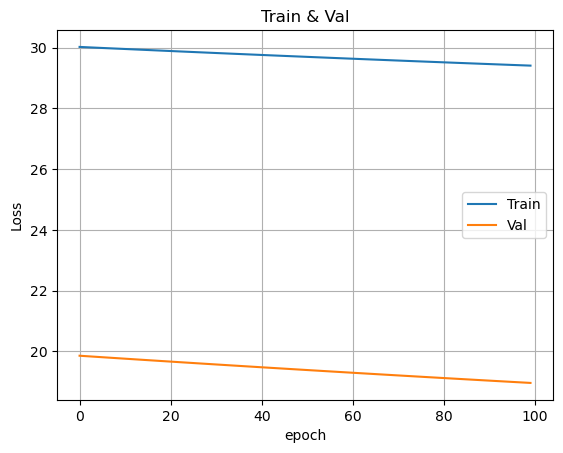

In [153]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt
plt.plot(loss[0], label='Train')
plt.plot(loss[1], label='Val')
plt.title('Train & Val')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 생소한 것들

adam_optim.zero_grad()는 PyTorch에서 Adam 옵티마이저를 사용할 때, 기울기(gradient)를 초기화하는 중요한 단계입니다. 이 함수는 역전파(backpropagation)를 통해 계산된 기울기 값을 누적하지 않고 매번 초기화하여, 각 미니배치마다 새로운 기울기를 계산하도록 해줍니다

`adam_optim.step()`는 PyTorch에서 **Adam 옵티마이저**를 사용할 때, **모델의 파라미터(가중치)를 업데이트**하는 함수입니다. 학습 과정에서 **역전파(backpropagation)**로 계산된 기울기를 사용해 모델의 파라미터를 **최적화**하는 역할을 합니다.

### 배경 설명

딥러닝에서 학습은 **손실 함수**를 최소화하기 위해, 모델의 파라미터를 조정하는 과정입니다. 이 과정에서 **경사하강법(Gradient Descent)**을 사용하여 손실 함수의 기울기를 계산하고, 이를 바탕으로 파라미터를 업데이트합니다. Adam은 경사하강법의 변형 알고리즘 중 하나로, 가중치를 업데이트하는 **효율적이고 빠른 방법**입니다.

### 코드 설명

```python
adam_optim.step()
```

- **`adam_optim`**: **Adam 옵티마이저** 객체입니다. `torch.optim.Adam()`으로 정의된 옵티마이저로, 모델의 파라미터를 업데이트하는 데 사용됩니다.
  
  ```python
  adam_optim = torch.optim.Adam(model.parameters(), lr=0.001)
  ```

- **`step()`**: **옵티마이저가 계산된 기울기**를 기반으로 모델의 파라미터를 업데이트하는 함수입니다. 이 함수는 `loss.backward()`로 역전파를 통해 계산된 기울기를 사용하여 **파라미터를 최적화**합니다.

### 학습 과정에서의 역할

1. **기울기 계산**:
   - `loss.backward()`를 사용해 **손실 함수의 기울기**를 계산합니다. 이 기울기는 모델의 각 파라미터에 대해 계산되며, 모델이 어떻게 학습해야 하는지 방향을 제공합니다.

2. **파라미터 업데이트**:
   - `adam_optim.step()`는 계산된 기울기를 사용하여, 모델의 **가중치와 편향** 같은 파라미터를 업데이트합니다.
   - Adam 옵티마이저는 파라미터의 기울기를 기반으로, 가중치를 어떻게 업데이트할지 자동으로 결정하며, **모멘텀**과 **적응형 학습률** 등의 기술을 적용합니다.

### 학습 루프에서의 `step()`과 `zero_grad()`의 관계

```python
for data, target in dataloader:
    adam_optim.zero_grad()  # 기울기 초기화
    output = model(data)    # 모델의 예측값 계산
    loss = loss_fn(output, target)  # 손실 계산
    loss.backward()  # 역전파로 기울기 계산
    adam_optim.step()  # 파라미터 업데이트
```

1. **`adam_optim.zero_grad()`**: 역전파 전에 파라미터의 **기울기를 0으로 초기화**합니다. 이전 미니배치에서 계산된 기울기가 누적되지 않도록 합니다.
2. **`loss.backward()`**: 손실 함수의 기울기를 계산하여 각 파라미터에 대해 저장합니다.
3. **`adam_optim.step()`**: 저장된 기울기를 사용하여 **파라미터를 업데이트**합니다. 이 단계에서 파라미터가 학습되고 최적화됩니다.

### Adam 옵티마이저의 특징

- **Adam(Adaptive Moment Estimation)**은 경사하강법의 변형 알고리즘으로, **모멘텀(Momentum)**과 **적응형 학습률(Adaptive Learning Rate)**을 결합한 방법입니다.
  - **모멘텀**: 기울기의 과거 정보를 사용하여, 더 빠르게 최적화하는 방법입니다.
  - **적응형 학습률**: 각 파라미터마다 학습률을 자동으로 조정하여, 변화가 많은 곳에서는 빠르게, 안정적인 곳에서는 느리게 학습합니다.

Adam 옵티마이저는 일반적인 경사하강법(SGD)보다 **더 빠르게 수렴**하며, 다양한 문제에서 **잘 동작**하는 것으로 알려져 있습니다.

### 요약:
- **`adam_optim.step()`**는 **Adam 옵티마이저**를 사용해 **기울기를 기반으로 모델의 파라미터를 업데이트**하는 함수입니다.
- 학습 과정에서 역전파로 계산된 기울기를 바탕으로, 모델의 가중치와 편향 등을 업데이트하여 모델이 학습하도록 돕습니다.
- `zero_grad()`로 기울기를 초기화하고, `backward()`로 기울기를 계산한 후, `step()`을 통해 파라미터를 업데이트하는 흐름이 기본적인 학습 과정입니다.

이 과정을 통해 모델이 데이터를 더 잘 학습하고, 최적의 성능을 낼 수 있도록 도와줍니다.